# Jet Energy Resolution Plotting

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from distributed.diagnostics.plugin import UploadDirectory
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import pickle
import correctionlib
from coffea.analysis_tools import PackedSelection
from dask.distributed import Client
from scipy.optimize import curve_fit
import csv
import pandas as pd

### Plotting the Distribution Widths and their Errors for all $p_T$ Bins

In [2]:
df_2016 = pd.read_csv('gaussian_fit_files/gaussian_parameters_2016.csv')
df_2017 = pd.read_csv('gaussian_fit_files/gaussian_parameters_2017.csv')
df_2018 = pd.read_csv('gaussian_fit_files/gaussian_parameters_2018.csv')

pt_bin_centers = [10.5, 11.5, 12.5, 13.5, 14.5, 16., 18.5, 21.5, 25., 28.5, 32.5, 37.5, 42.5, 51., 64.5, 81., 105., 135., 175., 250., 350., 475., 650., 875., 1250., 1750., 2250., 2750., 3250., 3750., 4500., 7500.]

def extract_sigma(df):
    sigmas = []
    for i in df['popt']:
        numeric_values = i.strip('[]').split()
        sigma_values = float(numeric_values[2])
        sigmas.append(sigma_values)
    return sigmas

def extract_sigma_err(df):
    sigma_errs = []
    for i in df['pcov']:
        numeric_values = i.strip('[]').split()
        sigma_err_values = np.sqrt(float(numeric_values[-1]))
        sigma_errs.append(sigma_err_values)
    return sigma_errs

sigmas_2016 = np.abs(extract_sigma(df_2016))
sigmas_2017 = np.abs(extract_sigma(df_2017))
sigmas_2018 = np.abs(extract_sigma(df_2018))

sigma_errs_2016 = extract_sigma_err(df_2016)
sigma_errs_2017 = extract_sigma_err(df_2017)
sigma_errs_2018 = extract_sigma_err(df_2018)

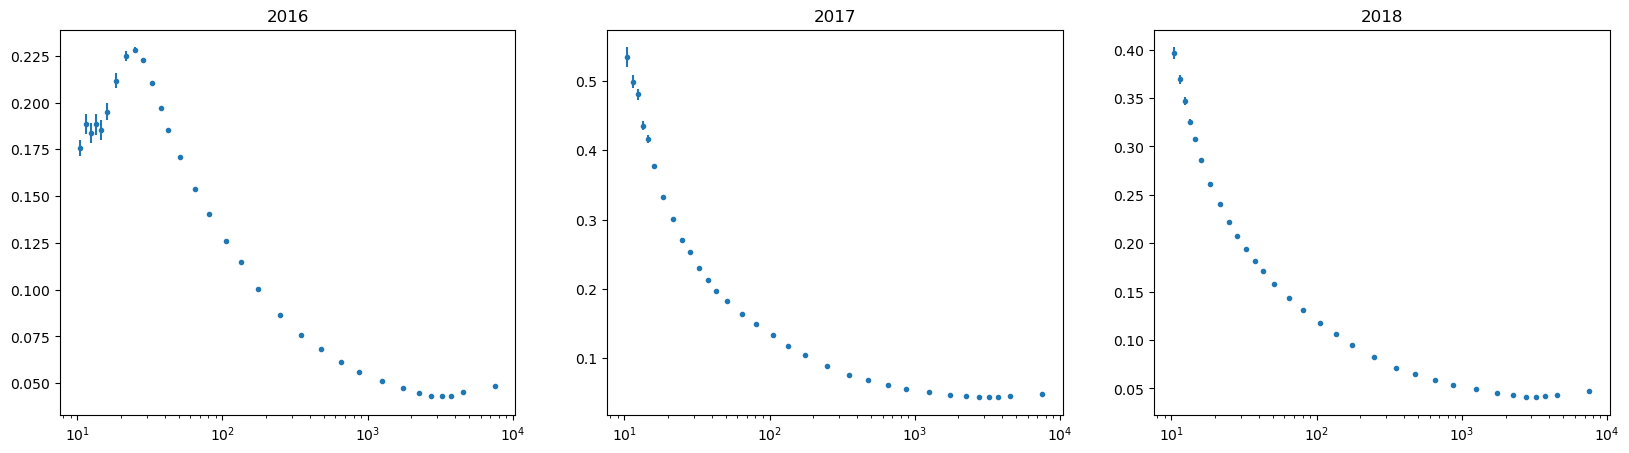

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

data = [(sigmas_2016, sigma_errs_2016, '2016'),  
        (sigmas_2017, sigma_errs_2017, '2017'), 
        (sigmas_2018, sigma_errs_2018, '2018')]

for i, (sigma_data, sigma_err, label) in enumerate(data):
    ax = axs[i]
    ax.errorbar(pt_bin_centers, sigma_data, yerr=sigma_err, fmt='.')
    ax.set_xscale("log")
    ax.set_title(label)

plt.show()

### Fitting the JER Curves to the Recommended JER Corrections

In [ ]:
def computeJER(pt, eta, rho, filename):
    df = pd.read_csv(filename, delimiter='\s+', skiprows=1, names=['eta_low', 'eta_high', 'rho_low', 'rho_high', 'unknown','pt_low', 'pt_high', 'par0', 'par1', 'par2', 'par3'])
    
    df = df[ (eta > df['eta_low']) &  (eta <= df['eta_high']) & (rho > df['rho_low']) & (rho <= df['rho_high']) ]
    p0 = df['par0']
    p1 = df['par1']
    p2 = df['par2']
    p3 = df['par3']
    x = pt
    return np.sqrt(p0*np.abs(p0)/(x*x)+p1*p1*np.power(x,p3) + p2*p2)

In [ ]:
jerfile = 'Summer20UL16_JRV3_MC_PtResolution_AK4PFchs.txt'
plt.errorbar(x=pt_bin_centers, y=[computeJER(pt=pt, eta=eta_values[i_eta], rho=rho_values[i_rho], filename=jerfile) for pt in pt_bin_centers], fmt=next(markers), linestyle="", markersize=5, markerfacecolor='none')